In [1]:
#QCCNN

In [2]:
#Imports
import qiskit
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.extensions import Initialize

In [3]:
#Class for quantum convolutional filter

class Quanvoluter:
    def __init__(self, kernel_size=2, stride=1):
        self.kernel_size = kernel_size
        self.stride = stride
        self.thetas = np.zeros((kernel_size, kernel_size))
        
    #This function converts grayscale values to r_y rotation values 
    
    def quantum_data_encoder(self, img):
        img = np.array(img)
        init_thetas = img * np.pi / 2
        return init_thetas
    
    #This function creates out quantum circuit(img_sec is 2 by 2 section of image)
    
    def circuit_builder(self, img_sec, thetas = None):
        if (thetas is None):
            thetas = self.thetas
        kernel_size = self.kernel_size
        thetas = thetas.flatten()
        
        img_sec = img_sec.flatten()
        qr = QuantumRegister(kernel_size * kernel_size, name="q")
        cr = ClassicalRegister(kernel_size * kernel_size, name="c")
        qc = QuantumCircuit(qr, cr)
        qubit_i = 0
        for img in img_sec:
            qc.ry(img, qubit_i)
            qubit_i += 1
        qubit_i = 0
        qc.barrier()
        for theta in thetas:
            qc.ry(theta, qubit_i)
            qubit_i += 1
        
        #CNOTS
        qubit_i = 0
        while(qubit_i < ((kernel_size * kernel_size) - 1)):
            qc.cx(qubit_i, qubit_i + 1)
            qubit_i += 2
            
        qubit_i = 1
        while(qubit_i < ((kernel_size * kernel_size) - 1)):
            qc.cx(qubit_i, qubit_i + 1)
            qubit_i += 2
        
        #MEASUREMENTS
        qc.barrier()
        
        qubit_i = 0
        while(qubit_i < ((kernel_size * kernel_size))):
            qc.measure(qubit_i, qubit_i)
            qubit_i += 1
        
        return qc
    
    #computes expectation of Z
    
    def corr_measure(self, circ):
        shots = 8192
        backend = qiskit.Aer.get_backend('qasm_simulator') 
        qobj = assemble(circ, shots=shots)
        result = backend.run(circ).result()
        counts = result.get_counts(circ)
        sum = 0
        for key in counts:
            key_arr = list(key)
            key_arr = np.array(key_arr)
            key_arr_ints = np.array([int(x) for x in key_arr])
            key_sum = np.sum(key_arr_ints)
            weighted_val = ((-1)**key_sum) * counts[key]
            sum = sum + weighted_val
        return sum / shots
    
    #img is set of init thetas for the image data 
    
    def feature_mapper(self, img): 
        kernel_size = self.kernel_size
        stride = self.stride

        rows, cols = np.shape(img)
        feature_map_rows = int(((rows - kernel_size) / stride) + 1)
        feature_map_cols = int(((cols - kernel_size) / stride) + 1)
        feature_map = np.zeros((feature_map_rows, feature_map_cols)) 
        i = 0
        row_offset = 0
        col_offset = 0
        
        while(i < feature_map_rows * feature_map_cols):
            img_sec = img[row_offset:(row_offset+kernel_size), col_offset:(col_offset+kernel_size)]
            circ = self.circuit_builder(img_sec)
            x = self.corr_measure(circ)
            feature_map[(i // feature_map_cols), (i % feature_map_cols)] = x
            i += 1
            col_offset += stride
            if (col_offset + kernel_size > cols):
                row_offset += stride
                col_offset = 0
        return feature_map
    
    #Helper function for quantum grad calcs
    
    def sub_grad_calc(self, img_sec):
        shift = np.pi / 2
        thetas = self.thetas
        thetas_copy = thetas.copy()
        grads = np.zeros(len(thetas), dtype=float)
        print(thetas)
        
        for i in range(len(thetas)):
            thetas_copy[i] += shift
            print(thetas_copy)
            pos_circ = self.circuit_builder(img_sec, thetas = thetas_copy)
            thetas_copy = thetas.copy()
            thetas_copy[i] -= shift
            print(thetas_copy)
            neg_circ = self.circuit_builder(img_sec, thetas = thetas_copy)
            thetas_copy = thetas.copy()
            grads[i] = 0.5 * (self.corr_measure(pos_circ) - self.corr_measure(neg_circ))
        
        return grads
    
    def grad_calc(self, img):
        shift = np.pi / 2
        thetas = self.thetas
        thetas_copy = thetas
        grads = np.zeros(len(thetas), dtype=float)
        
        #loop over all 2 by 2 windows, and add up all gradient calcs.
        
        kernel_size = self.kernel_size
        stride = self.stride

        rows, cols = np.shape(img)
        feature_map_rows = int(((rows - kernel_size) / stride) + 1)
        feature_map_cols = int(((cols - kernel_size) / stride) + 1)
        feature_map = np.zeros((feature_map_rows, feature_map_cols)) 
        i = 0
        row_offset = 0
        col_offset = 0
        
        while(i < feature_map_rows * feature_map_cols):
            img_sec = img[row_offset:(row_offset+kernel_size), col_offset:(col_offset+kernel_size)]
            grads += self.sub_grad_calc(img_sec)
            i += 1
            col_offset += stride
            if (col_offset + kernel_size > cols):
                row_offset += stride
                col_offset = 0
        
        return grads
        
    def thetas_updates(self, img):
        grads = self.grad_calc(img)
        self.thetas = self.thetas - grads

In [4]:
#test circuit building

In [5]:
img_sec_test = np.array([[0.5, 1], [0, 1]]) #Greyscale values

In [6]:
img_sec_test

array([[0.5, 1. ],
       [0. , 1. ]])

In [7]:
q_test = Quanvoluter()

In [8]:
theta_vals_test = q_test.quantum_data_encoder(img_sec_test)

In [9]:
theta_vals_test

array([[0.78539816, 1.57079633],
       [0.        , 1.57079633]])

In [10]:
#quantum data

In [11]:
test_circ = q_test.circuit_builder(theta_vals_test)

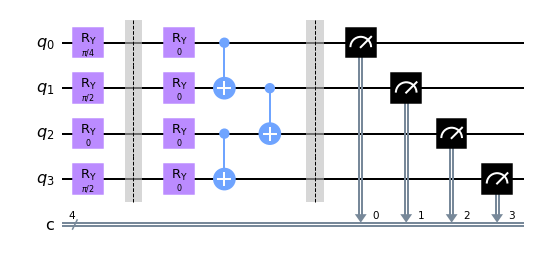

In [12]:
test_circ.draw(output = 'mpl')

In [13]:
#Test generalization to arbitrary kernel size

In [14]:
q_test_big = Quanvoluter(kernel_size = 4)

In [15]:
img_vals_test_big = [[1, 1, 0, 0.5], [1, 1, 0, 0.5], [0.5, 1, 0, 1],  [1, 1, 1, 1]]

In [16]:
theta_vals_test_big = q_test_big.quantum_data_encoder(img_vals_test_big)

In [17]:
theta_vals_test_big

array([[1.57079633, 1.57079633, 0.        , 0.78539816],
       [1.57079633, 1.57079633, 0.        , 0.78539816],
       [0.78539816, 1.57079633, 0.        , 1.57079633],
       [1.57079633, 1.57079633, 1.57079633, 1.57079633]])

In [18]:
test_circ_big = q_test_big.circuit_builder(theta_vals_test_big)

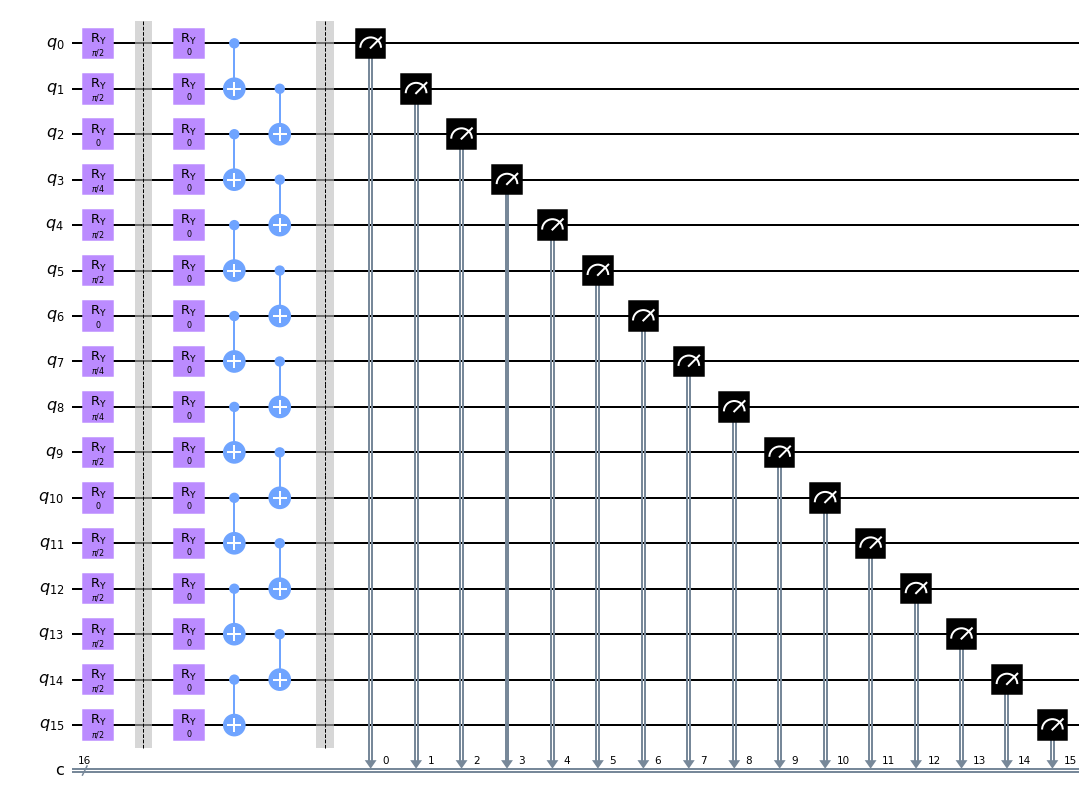

In [19]:
test_circ_big.draw(output='mpl')

In [20]:
#Continue

In [21]:
#Test circuit builder for a "learned" theta vector for second set of R_y gates

In [22]:
q_test.thetas = np.array([np.pi, np.pi / 2, 0, 3* np.pi/2])

In [23]:
test_circ = q_test.circuit_builder(theta_vals_test)

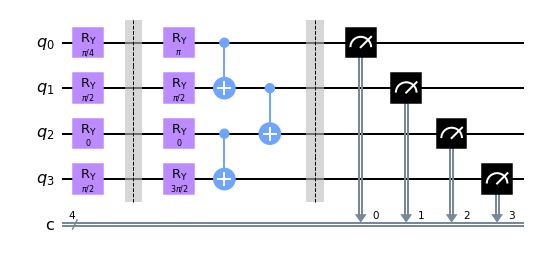

In [24]:
test_circ.draw(output='mpl')

In [25]:
#Continue

In [26]:
#Test correlational measurement

In [27]:
qr = QuantumRegister(4, name="q")
cr = ClassicalRegister(4, name="c")
special_circ = QuantumCircuit(qr, cr)

In [28]:
special_circ.x(0)

In [29]:
special_circ.barrier()

In [30]:
special_circ.measure(0, 0)
special_circ.measure(1, 1)
special_circ.measure(2, 2)
special_circ.measure(3, 3)

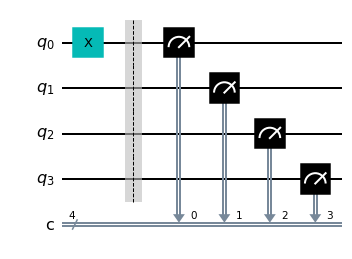

In [31]:
special_circ.draw(output='mpl')

In [32]:
q_test.corr_measure(special_circ)

-0.125

In [33]:
#negative one as expected. Next test should be positive one.

In [34]:
qr = QuantumRegister(4, name="q")
cr = ClassicalRegister(4, name="c")
special_circ = QuantumCircuit(qr, cr)

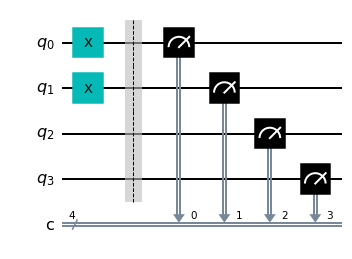

In [35]:
special_circ.x(0)
special_circ.x(1)
special_circ.barrier()
special_circ.measure(0, 0)
special_circ.measure(1, 1)
special_circ.measure(2, 2)
special_circ.measure(3, 3)
special_circ.draw(output='mpl')

In [36]:
q_test.corr_measure(special_circ)

0.125

In [37]:
#corr_measure

In [38]:
#Test subgradient

In [39]:
q_test.thetas = np.array([0.0, 0.0, 0.0, 0.0])

In [40]:
q_test.thetas

array([0., 0., 0., 0.])

In [41]:
q_test.sub_grad_calc(np.array([0.0,0.0,0.0,0.0]))

[0. 0. 0. 0.]
[1.57079633 0.         0.         0.        ]
[-1.57079633  0.          0.          0.        ]
[0.         1.57079633 0.         0.        ]
[ 0.         -1.57079633  0.          0.        ]
[0.         0.         1.57079633 0.        ]
[ 0.          0.         -1.57079633  0.        ]
[0.         0.         0.         1.57079633]
[ 0.          0.          0.         -1.57079633]


array([-0.00109863,  0.        ,  0.        , -0.00402832])

In [42]:
#sub_grad

In [43]:
test_img = np.array([[0.0,0.0],[0.0,0.0]])

In [44]:
q_test.thetas_updates(test_img)

[0. 0. 0. 0.]
[1.57079633 0.         0.         0.        ]
[-1.57079633  0.          0.          0.        ]
[0.         1.57079633 0.         0.        ]
[ 0.         -1.57079633  0.          0.        ]
[0.         0.         1.57079633 0.        ]
[ 0.          0.         -1.57079633  0.        ]
[0.         0.         0.         1.57079633]
[ 0.          0.          0.         -1.57079633]


In [45]:
q_test.thetas

array([-0.00231934,  0.        ,  0.        , -0.00036621])

In [46]:
#Continue

In [47]:
#Test feature mapper

In [48]:
test_img = np.array([[1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1]])

In [49]:
test_img

array([[1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]])

In [50]:
test_img = q_test.quantum_data_encoder(test_img)

In [51]:
test_img

array([[1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633],
       [1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633],
       [1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633],
       [1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633],
       [1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633]])

In [52]:
q_test.thetas = np.array([-np.pi/2, -np.pi/2, -np.pi/2, -np.pi/2])

In [53]:
#should map everything to one.

In [54]:
q_test.feature_mapper(test_img)

array([[0.125, 0.125, 0.125, 0.125],
       [0.125, 0.125, 0.125, 0.125],
       [0.125, 0.125, 0.125, 0.125],
       [0.125, 0.125, 0.125, 0.125]])

In [55]:
q_test.thetas = np.array([0.0, 0.0, 0.0, 0.0])

In [56]:
q_test.feature_mapper(test_img)

array([[-0.00097656,  0.00366211,  0.00244141,  0.00195312],
       [ 0.00292969,  0.00610352,  0.00390625, -0.00317383],
       [ 0.00366211,  0.00366211,  0.00219727,  0.00415039],
       [-0.00341797,  0.00610352,  0.00415039, -0.00463867]])

In [57]:
#The quantum convolutional filter appears to be working.

In [58]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

In [59]:
import torch
import torchvision

In [60]:
import tensorflow as tf

In [61]:
#Hybrid network class for a single convolutional layer.
class Hybrid(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = Quanvoluter()
        self.fc1 = nn.Linear(169, 25)
        self.fc2 = nn.Linear(25, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(torch.from_numpy(np.array([self.conv1.feature_mapper(x)])), 2))
        x = x.view(-1, 169)
        x = F.relu(self.fc1(x.float()))
        x = self.fc2(x)
        return F.log_softmax(x)

In [62]:
#Continue

In [63]:
#Modified class for CCNN

In [64]:
class CNet(nn.Module):
    def __init__(self):
        super(CNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, kernel_size=2)
        self.conv2 = nn.Conv2d(1, 1, kernel_size=2)
        self.fc1 = nn.Linear(36, 25)
        self.fc2 = nn.Linear(25, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 36)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)

In [65]:
#net = Hybrid()
net = CNet() 
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [66]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [188]:
import tetris

x_train, y_train = tetris.load_data(8000, 2)
x_test, y_test = tetris.load_data(2000, 2)

def transfer_boll(y):
    y = y == 'T'
    return y

y_train = [1 if i == 'S' else 0 for i in y_train]
y_test = [1 if i == 'S' else 0 for i in y_test]

train_data = [(x_train[i], y_train[i])for i in np.arange(len(x_train))]
test_data = [(x_test[i], y_test[i])for i in np.arange(len(x_test))]

TypeError: 'map' object is not subscriptable

In [182]:
train_loader = torch.utils.data.DataLoader(
  train_data,
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  test_data,
  batch_size=batch_size_test, shuffle=True)

TypeError: object of type 'map' has no len()

In [174]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [175]:
def train(epoch):
    net.train
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = net(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        #net.conv1.thetas_updates(data) 
        #back-propagation for the QCNN
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [176]:
def test():
    net.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = net(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
    pass

In [177]:
# Try not to run this block if it doesn't make any crush when you don't. 
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [178]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()
    pass

RuntimeError: Input type (double) and bias type (float) should be the same

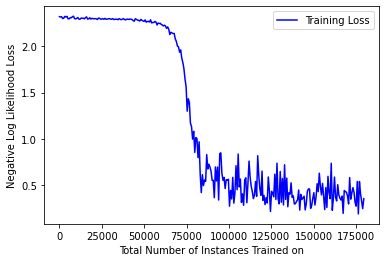

In [73]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.legend(['Training Loss', 'Test Loss'], loc='upper right')
plt.xlabel('Total Number of Instances Trained on')
plt.ylabel('Negative Log Likelihood Loss')
plt.show()